# Regression model—sound exposure level

This notebook explores and models the data collected from recordings of the natural acoustic environment over the urban-rural gradient near Innsbruck, Austria. The models are implemented as Bayesian models with the PyMC3 probabilistic programming library.

References:<br />
https://github.com/fonnesbeck/multilevel_modeling<br />
Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

#### Import statements

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas
import numpy
from os import path

In [3]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import seaborn

In [4]:
from pymc3 import glm, Model, NUTS, sample, stats, \
                  forestplot, traceplot, plot_posterior, summary, \
                  Normal, Uniform, Deterministic, StudentT
from pymc3.backends import Text

In [5]:
from figures.figutils import style

In [6]:
style.set_font()

In [7]:
seaborn.set()

#### Plot settings

#### Variable definitions

In [8]:
data_filepath = r"C:\Users\JDDein\OneDrive\Documents\alpine soundscapes\data\dataset_r.csv"

In [9]:
trace_output_path = r"C:\Users\JDDein\OneDrive\Documents\alpine soundscapes\data\model traces\sel"

In [10]:
seaborn_blue = seaborn.color_palette()[0]

## Load data

In [11]:
data = pandas.read_csv(data_filepath)
data = data.loc[data.site<=30]

sort data by site and then by visit

In [12]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

create sites variable for PyMC3 models

In [13]:
sites = numpy.copy(data_sorted.site.values) - 1

## Model 0 - emtpy model

$$
\begin{align}
y_{ts} \sim \mathcal{N}(\alpha_s + \epsilon_t, \sigma_y^2) \\
\alpha_s \sim \mathcal{N}(M + \epsilon_s, \sigma_\alpha^2) \\
\end{align}
$$

In [14]:
with Model() as model0:
    
    # Priors
    mu_grand = Normal('mu_grand', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_grand, tau=tau_a, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.sel)
    
    # sample model
    backend = Text(path.join(trace_output_path, "model0"))
    model0_samples = sample(draws=5000, random_seed=1, trace=backend, 
                            discard_tuned_samples=True, target_accept=0.95, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, a, sigma_a, mu_grand]
Sampling 4 chains: 100%|█████████████| 24000/24000 [00:48<00:00, 491.61draws/s]


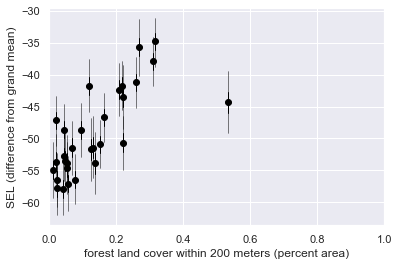

In [15]:
fig, ax = pyplot.subplots()

# organize results
model0_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()}).set_index('site')
model0_data['d2n_320m'] = data.groupby('site')['d2n_320m'].mean()
model0_data['quantiles'] = [stats.quantiles(model0_samples.a[:5000, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model0_data.sort_values(by='d2n_320m').iterrows():
    x = row['d2n_320m']
    ax.plot([x, x], [row['quantiles'][2.5], row['quantiles'][97.5]], color='black', linewidth=0.5)
    ax.plot([x, x], [row['quantiles'][25], row['quantiles'][75]], color='black', linewidth=1)
    ax.scatter([x], [row['quantiles'][50]], color='black', marker='o')

# format plot
l1 = ax.set_xlim([0, 1])
xl = ax.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax.set_ylabel("SEL (difference from grand mean)")

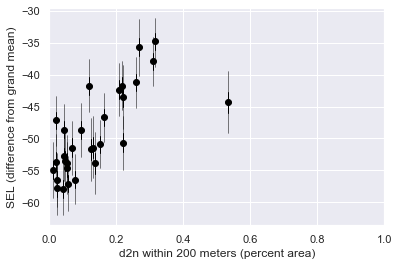

In [16]:
fig, ax = pyplot.subplots()

# organize results
model0_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()}).set_index('site')
model0_data['d2n_320m'] = data.groupby('site')['d2n_320m'].mean()
model0_data['quantiles'] = [stats.quantiles(model0_samples.a[:5000, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model0_data.sort_values(by='d2n_320m').iterrows():
    x = row['d2n_320m']
    ax.plot([x, x], [row['quantiles'][2.5], row['quantiles'][97.5]], color='black', linewidth=0.5)
    ax.plot([x, x], [row['quantiles'][25], row['quantiles'][75]], color='black', linewidth=1)
    ax.scatter([x], [row['quantiles'][50]], color='black', marker='o')

# format plot
l1 = ax.set_xlim([0, 1])
xl = ax.set_xlabel("d2n within 200 meters (percent area)")
yl = ax.set_ylabel("SEL (difference from grand mean)")

## Model 1—time and site predictors

$$
\begin{align}
\text{level 1} \\
y_{ts} \sim \mathcal{N}(\alpha_s + \beta_s T_t, \sigma_y^2) \\
\text{level 2} \\
\alpha_s \sim \mathcal{N}(\gamma_\alpha + \gamma_{\alpha s} L_s, \sigma_\alpha^2) \\
\beta_s \sim \mathcal{N}(\gamma_\beta + \gamma_{\beta s} L_s, \sigma_\beta^2) \\
\end{align}
$$

In [17]:
site_predictors = ['Buildings_5m', 'Buildings_10m', 'Buildings_20m', 'Buildings_40m',
        'Buildings_80m', 'Buildings_160m', 'Buildings_320m', 'Buildings_640m',
       'Buildings_1280m', 'Buildings_2560m', 'Other_constructed_areas_5m',
       'Other_constructed_areas_10m', 'Other_constructed_areas_20m',
       'Other_constructed_areas_40m', 'Other_constructed_areas_80m',
       'Other_constructed_areas_160m', 'Other_constructed_areas_320m',
       'Other_constructed_areas_640m', 'Other_constructed_areas_1280m',
       'Other_constructed_areas_2560m', 'Trees_5m', 'Trees_10m', 'Trees_20m',
       'Trees_40m', 'Trees_80m', 'Trees_160m', 'Trees_320m', 'Trees_640m',
       'Trees_1280m', 'Trees_2560m', 'Herbaceous_vegetation_5m',
       'Herbaceous_vegetation_10m', 'Herbaceous_vegetation_20m',
       'Herbaceous_vegetation_40m', 'Herbaceous_vegetation_80m',
       'Herbaceous_vegetation_160m', 'Herbaceous_vegetation_320m',
       'Herbaceous_vegetation_640m', 'Herbaceous_vegetation_1280m',
       'Herbaceous_vegetation_2560m', 'd2n_5m', 'd2n_10m', 'd2n_20m',
       'd2n_40m', 'd2n_80m', 'd2n_160m', 'd2n_320m', 'd2n_640m', 'd2n_1280m',
       'd2n_2560m',
]
for predictor in site_predictors:
    with Model() as model_1:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_sorted.groupby('site')[predictor].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_sorted.groupby('site')[predictor].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_sorted.week)

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.sel)

        # simulated
        #y_sim = Normal('y_sim', mu=y_hat, tau=tau_y, shape=y_hat.tag.test_value.shape)

        # sample model
        backend = Text(path.join(trace_output_path, "model1_{}".format(predictor)))
        model_1_samples = sample(draws=5000, random_seed=1, trace=backend, 
                                 discard_tuned_samples=True, target_accept=1, tune=20000, 
                                 compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, sigma_b, g_bs, g_b, a, sigma_a, g_as, g_a]
Sampling 4 chains: 100%|█████████████| 24000/24000 [03:37<00:00, 110.57draws/s]
There were 384 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8282541079561763, but should be close to 0.95. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9076614814980948, but should be close to 0.95. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 384 divergences after tuning. Increase `target_accept` or reparameterize.
The accept

The acceptance probability does not match the target. It is 0.39958240127947403, but should be close to 0.95. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 840 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7893721790539846, but should be close to 0.95. Try to increase the number of tuning steps.
There were 695 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8171453298214942, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2968 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39958240127947403, but should be close to 0.95. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increa

ValueError: Stop value in slice not supported.

In [ ]:
fig = pyplot.figure()

fig.set_figwidth(6.85)
fig.set_figheight(6.85/2)

ax_a = pyplot.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
ax_b = pyplot.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1, sharex=ax_a)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

# organize results
model_1_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()})
model_1_data['d2n_320m'] = data.groupby('site')['d2n_320m'].mean()
model_1_data['quantiles_a'] = [stats.quantiles(model_1_samples['a'][:5000][:, i]) for i in range(len(set(sites)))]
model_1_data['quantiles_b'] = [stats.quantiles(model_1_samples['b'][:5000][:, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model_1_data.sort_values(by='d2n_320m').iterrows():
    x = row['d2n_320m']
    #ax_a.plot([x, x], [row['quantiles_a'][2.5], row['quantiles_a'][97.5]], color='black', linewidth=0.5)
    ax_a.plot([x, x], [row['quantiles_a'][25], row['quantiles_a'][75]], color='black', linewidth=1)
    ax_a.scatter([x], [row['quantiles_a'][50]], color='black', marker='o')

# format plot
l1 = ax_a.set_xlim([0, 100])
xl = ax_a.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax_a.set_ylabel("sel (decibel difference from grand mean)")

# plot quantiles
for i, row in model_1_data.sort_values(by='d2n_320m').iterrows():
    x = row['d2n_320m']
    #ax_b.plot([x, x], [row['quantiles_b'][2.5], row['quantiles_b'][97.5]], color='black', linewidth=0.5)
    ax_b.plot([x, x], [row['quantiles_b'][25], row['quantiles_b'][75]], color='black', linewidth=1)
    ax_b.scatter([x], [row['quantiles_b'][50]], color='black', marker='o')

# format plot
l1 = ax_b.set_xlim([0, 1])
l2 = ax_b.set_ylim((-2, 2))
xl = ax_b.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax_b.set_ylabel("rate of change of sel (dB/week)")

In [ ]:
fig = pyplot.figure()

fig.set_figwidth(6.85)
fig.set_figheight(6.85/2)

ax_a = pyplot.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
ax_b = pyplot.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1, sharex=ax_a)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

# organize results
model_1_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()})
model_1_data['d2n_640m'] = data.groupby('site')['d2n_640m'].mean()
model_1_data['quantiles_a'] = [stats.quantiles(model_1_samples['a'][:5000][:, i]) for i in range(len(set(sites)))]
model_1_data['quantiles_b'] = [stats.quantiles(model_1_samples['b'][:5000][:, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model_1_data.sort_values(by='d2n_640m').iterrows():
    x = row['d2n_640m']
    #ax_a.plot([x, x], [row['quantiles_a'][2.5], row['quantiles_a'][97.5]], color='black', linewidth=0.5)
    ax_a.plot([x, x], [row['quantiles_a'][25], row['quantiles_a'][75]], color='black', linewidth=1)
    ax_a.scatter([x], [row['quantiles_a'][50]], color='black', marker='o')

# format plot
l1 = ax_a.set_xlim([0, 0.6])
xl = ax_a.set_xlabel("d2n within 500 meters (percent area)")
yl = ax_a.set_ylabel("sel (decibel difference from grand mean)")

# plot quantiles
for i, row in model_1_data.sort_values(by='d2n_640m').iterrows():
    x = row['d2n_640m']
    #ax_b.plot([x, x], [row['quantiles_b'][2.5], row['quantiles_b'][97.5]], color='black', linewidth=0.5)
    ax_b.plot([x, x], [row['quantiles_b'][25], row['quantiles_b'][75]], color='black', linewidth=1)
    ax_b.scatter([x], [row['quantiles_b'][50]], color='black', marker='o')

# format plot
l1 = ax_b.set_xlim([0, 0.6])
l2 = ax_b.set_ylim((-2, 2))
xl = ax_b.set_xlabel("d2n within 500 meters (percent area)")
yl = ax_b.set_ylabel("rate of change of sel (dB/week)")

## Model 2—environmental predictors

$$
\begin{align}
\text{level 1} \\
y_{ts} \sim \mathcal{N}(\alpha_s + \beta_s T_t, \sigma_y^2) \\
\text{level 2} \\
\alpha_s \sim \mathcal{N}(\gamma_\alpha + \gamma_{\alpha s} L_s, \sigma_\alpha^2) \\
\beta_s \sim \mathcal{N}(\gamma_\beta + \gamma_{\beta s} L_s, \sigma_\beta^2) \\
\end{align}
$$

In [23]:
measurement_predictors = [
    'temperature', 'wind_speed', 'precipitation', 'pressure',
]
for predictor in measurement_predictors:
    with Model() as model2a:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_sorted.groupby('site')['forest_200m'].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # time slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_sorted.groupby('site')['forest_200m'].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # temp slope
        #g_c = Normal('g_c', mu=0, tau=0.001)
        #g_cs = Normal('g_cs', mu=0, tau=0.001)
        #sigma_c = Uniform('sigma_c', lower=0, upper=100)
        #tau_c = sigma_c**-2
        #mu_c = g_c + (g_cs * data_sorted.groupby('site')['forest_200m'].mean())
        #c = Normal('c', mu=mu_c, tau=tau_c, shape=len(set(sites)))
        c = Uniform('c', lower=-100, upper=100)

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_sorted.week) + (c * data_sorted[predictor])

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.sel)

        # simulated
        #y_sim = Normal('y_sim', mu=y_hat, tau=tau_y, shape=y_hat.tag.test_value.shape)

        # sample model
        backend = SQLite(path.join(trace_output_path, "model2a_{0}.sqlite".format(predictor)))
        model_2_samples = sample(draws=10000, step=NUTS(), random_seed=1, trace=backend)

100%|██████████| 10000/10000 [17:43<00:00,  9.41it/s]


In [24]:
measurement_predictors = [
    'temperature', 'wind_speed', 'precipitation', 'pressure',
]
for predictor in measurement_predictors:
    with Model() as model2b:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_sorted.groupby('site')['forest_200m'].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # time slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_sorted.groupby('site')['forest_200m'].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # predictor slope
        g_c = Normal('g_c', mu=0, tau=0.001)
        g_cs = Normal('g_cs', mu=0, tau=0.001)
        sigma_c = Uniform('sigma_c', lower=0, upper=100)
        tau_c = sigma_c**-2
        mu_c = g_c + (g_cs * data_sorted.groupby('site')['forest_200m'].mean())
        c = Normal('c', mu=mu_c, tau=tau_c, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_sorted.week) + (c[sites] * data_sorted[predictor])

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.sel)

        # simulated
        #y_sim = Normal('y_sim', mu=y_hat, tau=tau_y, shape=y_hat.tag.test_value.shape)

        # sample model
        backend = SQLite(path.join(trace_output_path, "model2b_{0}.sqlite".format(predictor)))
        model_2_samples = sample(draws=10000, step=NUTS(), random_seed=1, trace=backend)

INFO (theano.gof.compilelock): Waiting for existing lock by process '29643' (I am process '29703')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/Jake/.theano/compiledir_Darwin-16.6.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir
100%|██████████| 10000/10000 [19:32<00:00,  8.53it/s]


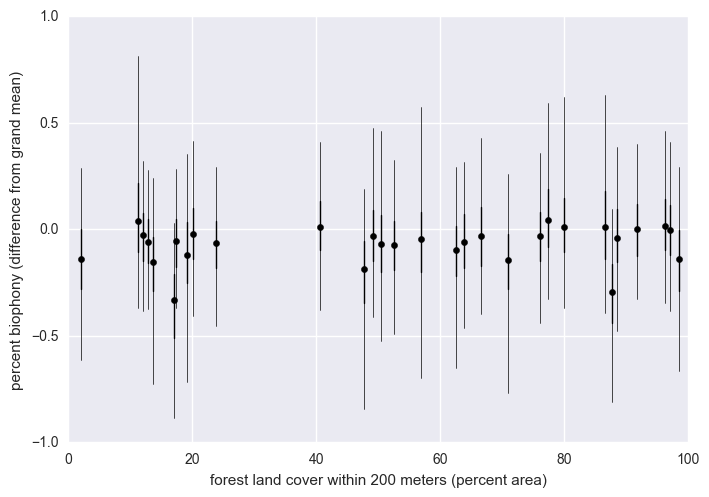

In [26]:
fig, ax = pyplot.subplots()

# organize results
model_2_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()})
model_2_data['forest_200m'] = data_sorted.forest_200m.unique()
model_2_data['quantiles'] = [stats.quantiles(model_2_samples['c'][:1000][:, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model_2_data.sort_values(by='forest_200m').iterrows():
    x = row['forest_200m']
    ax.plot([x, x], [row['quantiles'][2.5], row['quantiles'][97.5]], color='black', linewidth=0.5)
    ax.plot([x, x], [row['quantiles'][25], row['quantiles'][75]], color='black', linewidth=1)
    ax.scatter([x], [row['quantiles'][50]], color='black', marker='o')

# format plot
l1 = ax.set_xlim([0, 100])
xl = ax.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax.set_ylabel("percent biophony (difference from grand mean)")